In [16]:
########################################
# Imports
########################################
from firedrake import *
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd  # OB2025: alias for timing utilities (not used below)
import numpy as np  # OB2025: numerical utilities; used for np.power in boundary term
import matplotlib   # OB2025: plotting backend (not used below)


In [17]:
########################################
# Mesh and Coordinates
########################################
m  = 20              # number of 1D mesh cells (elements) along y
Ly = 0.85            # domain length in y-direction
dy = Ly/m            # uniform cell size (mesh spacing) in y
mesh = IntervalMesh(m, 0 , Ly)  # 1D mesh from y=0 to y=Ly with m cells
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh)   # continuous spatial coordinate function y on the mesh


In [18]:

########################################
# Time Definitions
########################################
t   = 0.0            # current simulation time
end = 150.0          # final simulation time
Ntm = 75             # number of measurement/diagnostic outputs
dtmeas = end/Ntm     # interval between outputs
tmeas = dtmeas       # next output time threshold


In [19]:
########################################
# Function Space
########################################
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 3                              # polynomial degree for CG space
V = FunctionSpace(mesh, "CG", nCG)   # scalar continuous Galerkin space P^nCG on mesh


In [20]:
########################################
# Timestep
########################################
CFL = 2.3                          # stability/control factor used to set timestep
Dt = CFL*0.5*dy*dy                 # explicit-like dt estimate ~ O(dy^2); used as fixed step here
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt)                  # Firedrake Constant for dt used in variational forms


In [21]:
########################################
# Time Discretization
########################################
theta = 0.5                        # time discretization parameter: 0=explicit, 1/2=CN, 1=implicit


In [22]:
########################################
# Physical Constants and Case Selection
########################################
mpor  = 0.3                        # effective porosity (-)
sigma = 0.8                        # storativity/porosity scaling (-)
Lc    = 0.05                       # characteristic canal width/length scale (m)
kperm = 1e-8                       # permeability (m^2)
w     = 0.1                        # canal width (m) [not used downstream]
R     = 0.000125                   # recharge/source term (m/s)
nu    = 1.0e-6                     # kinematic viscosity of water (m^2/s)
g     = 9.81                       # gravitational acceleration (m/s^2)
alpha = kperm/( nu * mpor * sigma )  # hydraulic diffusivity coefficient in PDE
gam   = Lc/( mpor*sigma )            # canal-storage coupling coefficient
fac2  = sqrt(g)/( mpor*sigma )       # weir-law prefactor in boundary flux
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
nncase = 1                         # selects boundary condition model (0: Dirichlet, 1: weir-law)


In [23]:
########################################
# Initial Condition
########################################
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
h_prev = Function(V).interpolate(0.0 + 0.0*y)  # initial groundwater head h^n (flat zero field)


In [24]:
########################################
# Output
########################################
outfile = VTKFile("./Results/groundwater_onnob.pvd")  # PVD output file for Paraview

outfile.write(h_prev , t = t )   # write initial state at t=0


In [25]:
########################################
# Variational Forms
########################################
# h will be the equivalent to h^n+1 in our timestepping scheme

phi = TestFunction(V)            # test function for variational formulation

def flux ( h , phi , R ):        # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )


In [26]:
## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

########################################
# Boundary Conditions and Solvers

# Possible Formulations:
# nncase = 0: Dirichlet BC at y=Ly
# nncase = 1: Weir-law BC at y=0 coupling to canal section
# Possible time discretisation given Weir-law BC:
# theta = 0: explicit/IMEX time stepping
# theta = 0.5: Crank-Nicholson time stepping
# theta = 1: implicit time stepping
########################################
if nncase == 0:
    # Provide intial guess to non linear solve
     h = Function(V)                                       # unknown groundwater head at new time
     h.assign(h_prev)                                      # initial guess for nonlinear iteration
     F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx  # residual form
    # Boundary conditions: Condition at Ly satisfied weakly
     bc1 = DirichletBC(V, 0.07, 1)                        # Dirichlet head at boundary id 1 (y=Ly)
     h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)  # nonlinear variational problem

elif nncase == 1:
   if theta == 0.0: # Matches (31)
      h, out = TrialFunction(V), Function(V)              # trial (unknown) and solution storage for linear step
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)             # left-hand side bilinear form with canal coupling
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R) ) *dx # interior right-hand side using previous step
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29): boundary RHS with weir law
      explicit_problem = LinearVariationalProblem(aa, L, out)  # linear problem for explicit theta=0
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij', 
          'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})  # direct solve
   elif theta > 0.0: # Matches (30) when theta=1/2
      h = Function(V)                                     # unknown groundwater head at new time
      h.assign(h_prev)                                    # start Newton iteration from previous head
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx  # interior residual
      # Add boundary contributions at y = 0: 
      F2 = ( gam*phi*(h-h_prev)/dt
                + theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)
                + (1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)  # weir-law boundary flux
      h_problem = NonlinearVariationalProblem( F+F2 , h )         # nonlinear problem with boundary term
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})  # direct Newton linearization solve


In [30]:
end = 100

In [31]:
########################################
# Time Loop
########################################
ys = np.linspace(0,Ly,100)  
values: list[list] = []
times: list = []
while (t < end):
    # First we increase time
    t += Dt                                  # advance time by fixed step
    # Use the solver and then update values for next timestep
    if theta == 0.0:
        explicit_solver.solve()            # solve linear explicit/IMEX step
        h_prev.assign(out)                # update stored head with new solution
    elif theta > 0.0:
        h_solver.solve()                  # solve nonlinear step (e.g., CN/implicit)
        h_prev.assign(h)                  # update stored head with new solution
    # Write output to file for paraview visualisation
    if t>tmeas:
     print('Time is: ',t)                 # periodic progress output
     times.append(t)
     values.append([h_prev.at(x) for x in ys])
     tmeas = tmeas+dtmeas                 # schedule next output time
     outfile.write(h_prev , t = t )       # write field to Paraview file
# End while time loop

Time is:  22.001569999996498


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  24.00190156249593
Time is:  26.000155937495364
Time is:  28.000487499994797
Time is:  30.00081906249423
Time is:  32.00115062499366


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  34.001482187493096
Time is:  36.00181374999253
Time is:  38.00006812499196
Time is:  40.000399687491395
Time is:  42.00073124999083
Time is:  44.00106281249026
Time is:  46.001394374989694
Time is:  48.00172593748913
Time is:  50.00205749998856
Time is:  52.00031187498799
Time is:  54.000643437487426
Time is:  56.00097499998686
Time is:  58.00130656248629
Time is:  60.001638124985725
Time is:  62.00196968748516
Time is:  64.00022406248459
Time is:  66.00055562499087
Time is:  68.00088718749714
Time is:  70.00121875000342
Time is:  72.00155031250969
Time is:  74.00188187501597
Time is:  76.00013625002224
Time is:  78.00046781252851
Time is:  80.00079937503479
Time is:  82.00113093754106
Time is:  84.00146250004734
Time is:  86.00179406255361
Time is:  88.00004843755988
Time is:  90.00038000006616
Time is:  92.00071156257243
Time is:  94.00104312507871
Time is:  96.00137468758498
Time is:  98.00170625009126
Time is:  100.00203781259754


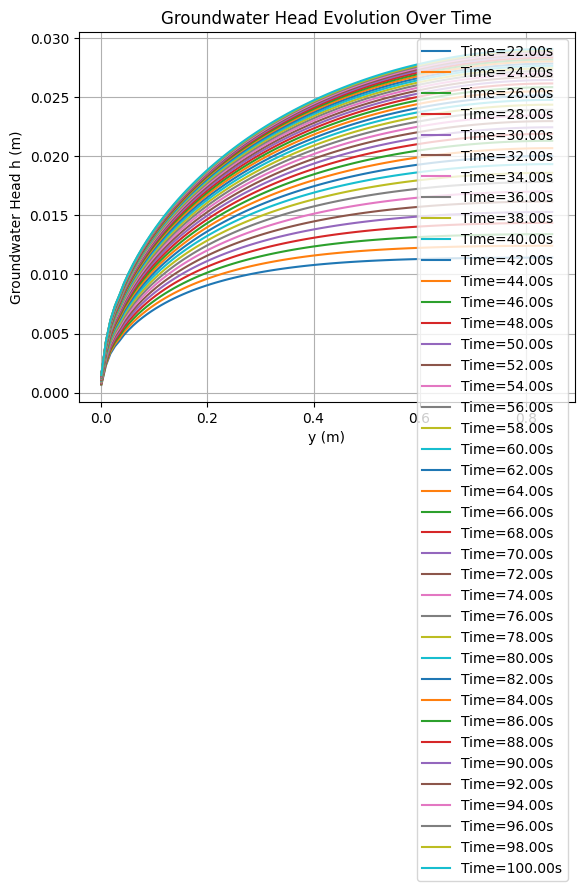

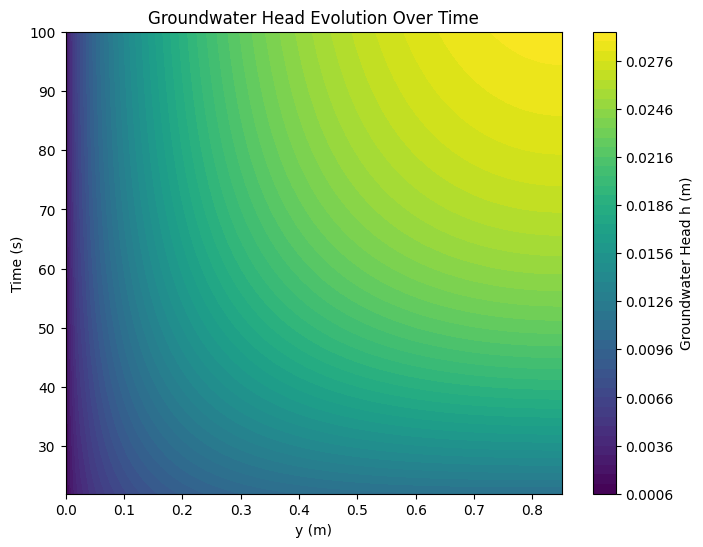

In [32]:
import matplotlib.pyplot as plt
for i in range(len(times)):
    plt.plot(ys, values[i], label=f'Time={times[i]:.2f}s')
plt.xlabel('y (m)')
plt.ylabel('Groundwater Head h (m)')
plt.title('Groundwater Head Evolution Over Time')
plt.legend()
plt.grid()
plt.show()

# Heatmap plot with horizontal axis as y and vertical axis as time
import matplotlib.pyplot as plt

Y, T = np.meshgrid(ys, times)
Z = np.array(values)
plt.figure(figsize=(8, 6))
plt.contourf(Y, T, Z, levels=50, cmap='viridis')
plt.colorbar(label='Groundwater Head h (m)')
plt.xlabel('y (m)')
plt.ylabel('Time (s)')
plt.title('Groundwater Head Evolution Over Time')
plt.show()

In [41]:
R_max = 0.000125
rainfall_periods  = [0, 1, 2, 4, 9]
rainfall_probabilities = [0.35, 0.3, 0.2, 0.1, 0.05]

# Time loop with variable rainfall every 10s 
end = 20
t = 0.0
t_10 = 0
tmeas = dtmeas
step = 0

ys = np.linspace(0,Ly,100)  
values: list[list] = []
times: list = []
Rs: list[bool] = [] # to store whether raining or not.
while (t < end):
    step += 1
    # First we increase time
    t += Dt  # advance time by fixed step
    if t >= t_10:
        rain_period = np.random.choice(rainfall_periods, p=rainfall_probabilities)
        t_10 += 10
        if rain_period != 0:
            R = R_max
            print(f'It is raining for {rain_period} seconds starting at time {t:.2f}s, step {step}.')
    if t >= t_10 - 10 + rain_period:
        R = 0
    Rs.append(R != 0)
    # Use the solver and then update values for next timestep
    if theta == 0.0:    
        explicit_solver.solve()            # solve linear explicit/IMEX step
        h_prev.assign(out)                # update stored head with new solution
    elif theta > 0.0:
        h_solver.solve()                  # solve nonlinear step (e.g., CN/implicit)
        h_prev.assign(h)                  # update stored head with new solution
    # Write output to file for paraview visualisation
    if t>tmeas:
        print('Time is: ',t, '. Step is', step)                 # periodic progress output
        times.append(t)
        values.append([h_prev.at(x) for x in ys])
        tmeas = tmeas+dtmeas                 # schedule next output time
        outfile.write(h_prev , t = t )       # write field to Paraview file

    


It is raining for 1 seconds starting at time 0.00s, step 1.
Time is:  2.000331562500031 . Step is 963


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  4.000663124999892 . Step is 1926
Time is:  6.00099468750018 . Step is 2889
Time is:  8.001326250000467 . Step is 3852
It is raining for 4 seconds starting at time 10.00s, step 4815.
Time is:  10.0016578124999 . Step is 4815
Time is:  12.001989374999333 . Step is 5778
Time is:  14.000243749998766 . Step is 6740
Time is:  16.0005753124982 . Step is 7703
Time is:  18.000906874997632 . Step is 8666
It is raining for 1 seconds starting at time 20.00s, step 9629.
Time is:  20.001238437497065 . Step is 9629


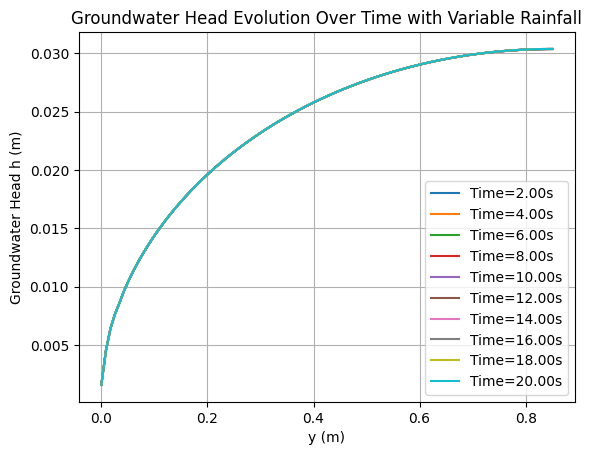

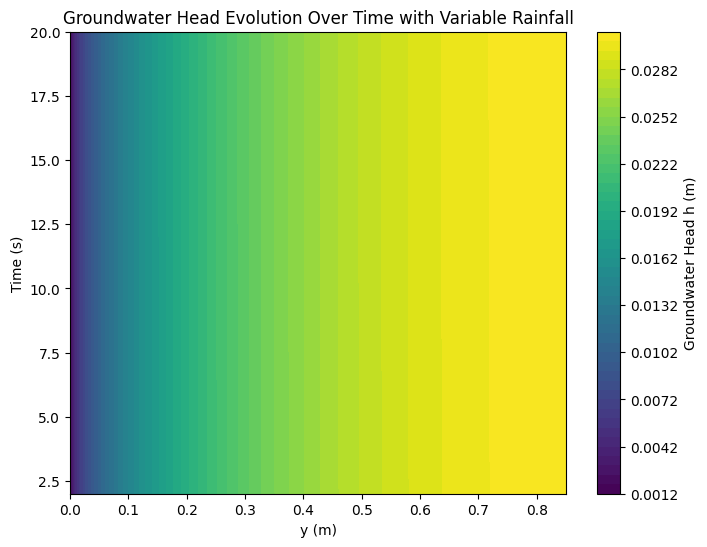

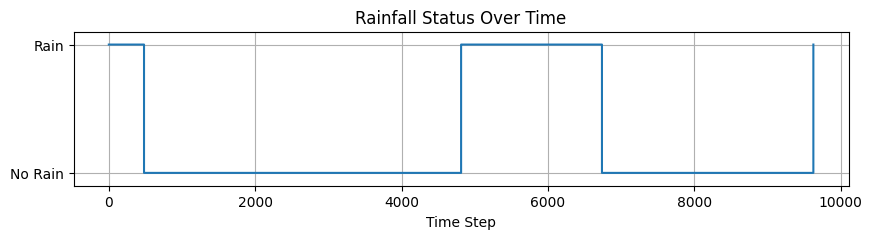

In [42]:
# Plot for variable rainfall
import matplotlib.pyplot as plt
for i in range(len(times)):
    plt.plot(ys, values[i], label=f'Time={times[i]:.2f}s')
plt.xlabel('y (m)')
plt.ylabel('Groundwater Head h (m)')
plt.title('Groundwater Head Evolution Over Time with Variable Rainfall')
plt.legend()
plt.grid()
plt.show()

# Heatmap plot with horizontal axis as y and vertical axis as time
import matplotlib.pyplot as plt
Y, T = np.meshgrid(ys, times)
Z = np.array(values)
plt.figure(figsize=(8, 6))
plt.contourf(Y, T, Z, levels=50, cmap='viridis')
plt.colorbar(label='Groundwater Head h (m)')
plt.xlabel('y (m)')
plt.ylabel('Time (s)')
plt.title('Groundwater Head Evolution Over Time with Variable Rainfall')
plt.show()

# Plot rainfall status
plt.figure(figsize=(10, 2))
plt.plot(range(len(Rs)), Rs, drawstyle='steps-post')
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ['No Rain', 'Rain'])
plt.xlabel('Time Step')
plt.title('Rainfall Status Over Time')
plt.grid()